In [110]:
%matplotlib notebook


import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt 
import time

In [111]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [112]:
dataset_root_dir = "C:\\Users\\ER\\Desktop\\Comp_photo_project_achyutha\\BSDS300\\images"

In [113]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')   
        # random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [114]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [115]:
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))

<IPython.core.display.Javascript object>


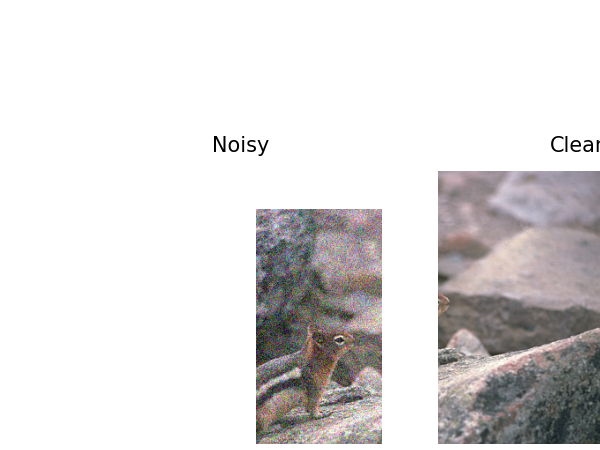

image size is torch.Size([3, 320, 320]).


In [116]:
x = test_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

In [117]:
import os
import time
import torch
from torch import nn
import torch.utils.data as td
from abc import ABC, abstractmethod


class NeuralNetwork(nn.Module, ABC):
    """An abstract class representing a neural network.

    All other neural network should subclass it. All subclasses should override
    ``forward``, that makes a prediction for its input argument, and
    ``criterion``, that evaluates the fit between a prediction and a desired
    output. This class inherits from ``nn.Module`` and overloads the method
    ``named_parameters`` such that only parameters that require gradient
    computation are returned. Unlike ``nn.Module``, it also provides a property
    ``device`` that returns the current device in which the network is stored
    (assuming all network parameters are stored on the same device).
    """

    def __init__(self):
        super(NeuralNetwork, self).__init__()

    @property
    def device(self):
        # This is important that this is a property and not an attribute as the
        # device may change anytime if the user do ``net.to(newdevice)``.
        return next(self.parameters()).device

    def named_parameters(self, recurse=True):
        nps = nn.Module.named_parameters(self)
        for name, param in nps:
            if not param.requires_grad:
                continue
            yield name, param

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def criterion(self, y, d):
        pass


class StatsManager(object):
    """
    A class meant to track the loss during a neural network learning experiment.

    Though not abstract, this class is meant to be overloaded to compute and
    track statistics relevant for a given task. For instance, you may want to
    overload its methods to keep track of the accuracy, top-5 accuracy,
    intersection over union, PSNR, etc, when training a classifier, an object
    detector, a denoiser, etc.
    """

    def __init__(self):
        self.init()

    def __repr__(self):
        """Pretty printer showing the class name of the stats manager. This is
        what is displayed when doing ``print(stats_manager)``.
        """
        return self.__class__.__name__

    def init(self):
        """Initialize/Reset all the statistics"""
        self.running_loss = 0
        self.number_update = 0

    def accumulate(self, loss, x=None, y=None, d=None):
        """Accumulate statistics

        Though the arguments x, y, d are not used in this implementation, they
        are meant to be used by any subclasses. For instance they can be used
        to compute and track top-5 accuracy when training a classifier.

        Arguments:
            loss (float): the loss obtained during the last update.
            x (Tensor): the input of the network during the last update.
            y (Tensor): the prediction of by the network during the last update.
            d (Tensor): the desired output for the last update.
        """
        self.running_loss += loss
        self.number_update += 1

    def summarize(self):
        """Compute statistics based on accumulated ones"""
        return self.running_loss / self.number_update


class Experiment(object):
    """
    A class meant to run a neural network learning experiment.

    After being instantiated, the experiment can be run using the method
    ``run``. At each epoch, a checkpoint file will be created in the directory
    ``output_dir``. Two files will be present: ``checkpoint.pth.tar`` a binary
    file containing the state of the experiment, and ``config.txt`` an ASCII
    file describing the setting of the experiment. If ``output_dir`` does not
    exist, it will be created. Otherwise, the last checkpoint will be loaded,
    except if the setting does not match (in that case an exception will be
    raised). The loaded experiment will be continued from where it stopped when
    calling the method ``run``. The experiment can be evaluated using the method
    ``evaluate``.

    Attributes/Properties:
        epoch (integer): the number of performed epochs.
        history (list): a list of statistics for each epoch.
            If ``perform_validation_during_training``=False, each element of the
            list is a statistic returned by the stats manager on training data.
            If ``perform_validation_during_training``=True, each element of the
            list is a pair. The first element of the pair is a statistic
            returned by the stats manager evaluated on the training set. The
            second element of the pair is a statistic returned by the stats
            manager evaluated on the validation set.

    Arguments:
        net (NeuralNetork): a neural network.
        train_set (Dataset): a training data set.
        val_set (Dataset): a validation data set.
        stats_manager (StatsManager): a stats manager.
        output_dir (string, optional): path where to load/save checkpoints. If
            None, ``output_dir`` is set to "experiment_TIMESTAMP" where
            TIMESTAMP is the current time stamp as returned by ``time.time()``.
            (default: None)
        batch_size (integer, optional): the size of the mini batches.
            (default: 16)
        perform_validation_during_training (boolean, optional): if False,
            statistics at each epoch are computed on the training set only.
            If True, statistics at each epoch are computed on both the training
            set and the validation set. (default: False)
    """

    def __init__(self, net, train_set, val_set, optimizer, stats_manager,
                 output_dir=None, batch_size=16, perform_validation_during_training=False):

        # Define data loaders
        train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                     drop_last=True, pin_memory=True)
        val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=False,
                                   drop_last=True, pin_memory=True)

        # Initialize history
        history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = 'experiment_{}'.format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k !='self'}
        self.__dict__.update(locs)

        # Load checkpoint and check compatibility
        if os.path.isfile(config_path):
            with open(config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                        "Cannot create this experiment: "
                        "I found a checkpoint conflicting with the current setting.")
            self.load()
        else:
            self.save()

    @property
    def epoch(self):
        """Returns the number of epochs already performed."""
        return len(self.history)

    def setting(self):
        """Returns the setting of the experiment."""
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size,
                'PerformValidationDuringTraining': self.perform_validation_during_training}

    def __repr__(self):
        """Pretty printer showing the setting of the experiment. This is what
        is displayed when doing ``print(experiment)``. This is also what is
        saved in the ``config.txt`` file.
        """
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
        return string

    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}

    def load_state_dict(self, checkpoint):
        """Loads the experiment from the input checkpoint."""
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']

        # The following loops are used to fix a bug that was
        # discussed here: https://github.com/pytorch/pytorch/issues/2830
        # (it is supposed to be fixed in recent PyTorch version)
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.net.device)

    def save(self):
        """Saves the experiment on disk, i.e, create/update the last checkpoint."""
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)

    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.net.device)
        self.load_state_dict(checkpoint)
        del checkpoint

    def run(self, num_epochs, plot=None):
        """Runs the experiment, i.e., trains the network using backpropagation
        based on the optimizer and the training set. Also performs statistics at
        each epoch using the stats manager.

        Arguments:
            num_epoch (integer): the number of epoch to perform.
            plot (func, optional): if not None, should be a function taking a
                single argument being an experiment (meant to be ``self``).
                Similar to a visitor pattern, this function is meant to inspect
                the current state of the experiment and display/plot/save
                statistics. For example, if the experiment is run from a
                Jupyter notebook, ``plot`` can be used to display the evolution
                of the loss with ``matplotlib``. If the experiment is run on a
                server without display, ``plot`` can be used to show statistics
                on ``stdout`` or save statistics in a log file. (default: None)
        """
        self.net.train()
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        if plot != None:
            plot(self)
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            self.stats_manager.init()
            for x, d in self.train_loader:
                x, d = x.to(self.net.device), d.to(self.net.device)
                self.optimizer.zero_grad()
                y = self.net.forward(x)
                loss = self.net.criterion(y, d)
                loss.backward()
                self.optimizer.step()
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), x, y, d)
            if not self.perform_validation_during_training:
                self.history.append(self.stats_manager.summarize())
                print("Epoch {} | Time: {:.2f}s | Training Loss: {:.6f}".format(
                    self.epoch, time.time() - s, self.history[-1][0]['loss']))
            else:
                self.history.append(
                    (self.stats_manager.summarize(), self.evaluate()))
                print("Epoch {} | Time: {:.2f}s | Training Loss: {:.6f} | Evaluation Loss: {:.6f}".format(
                    self.epoch, time.time() - s, self.history[-1][0]['loss'], self.history[-1][1]['loss']))
            
            self.save()
            if plot != None:
                plot(self)
        print("Finish training for {} epochs".format(num_epochs))

    def evaluate(self):
        """Evaluates the experiment, i.e., forward propagates the validation set
        through the network and returns the statistics computed by the stats
        manager.
        """
        self.stats_manager.init()
        self.net.eval()
        with torch.no_grad():
            for x, d in self.val_loader:
                x, d = x.to(self.net.device), d.to(self.net.device)
                y = self.net.forward(x)
                loss = self.net.criterion(y, d)
                self.stats_manager.accumulate(loss.item(), x, y, d)
        self.net.train()
        return self.stats_manager.summarize()

In [118]:
class NNRegressor(NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

In [119]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

<IPython.core.display.Javascript object>


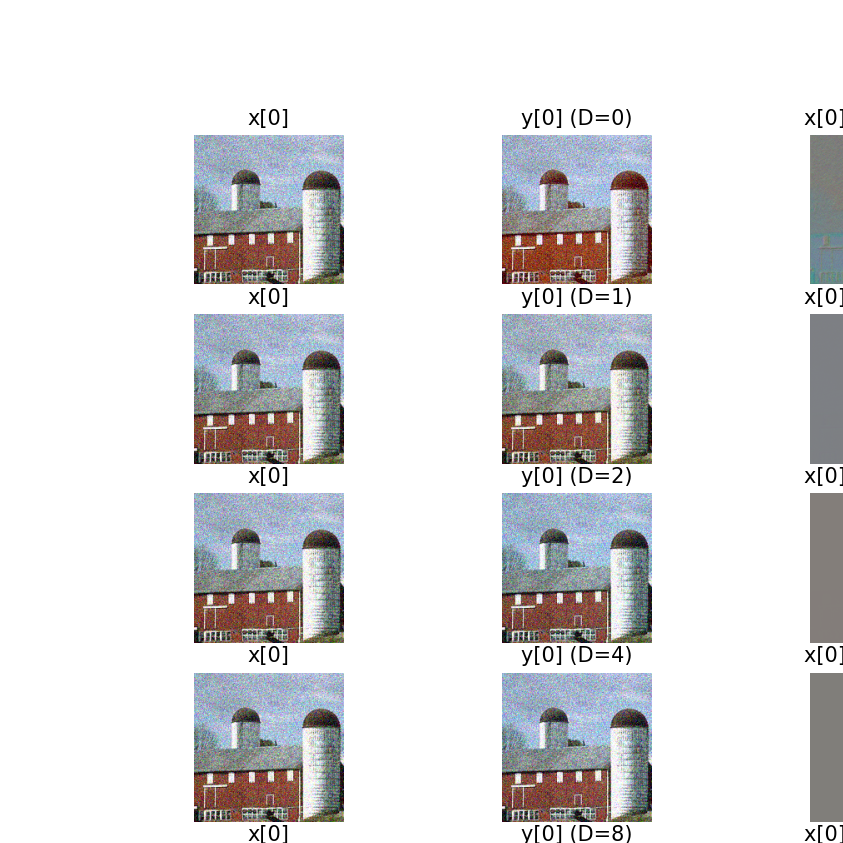

In [120]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x) # 4-d
    # 3-d
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')


In [121]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

<IPython.core.display.Javascript object>


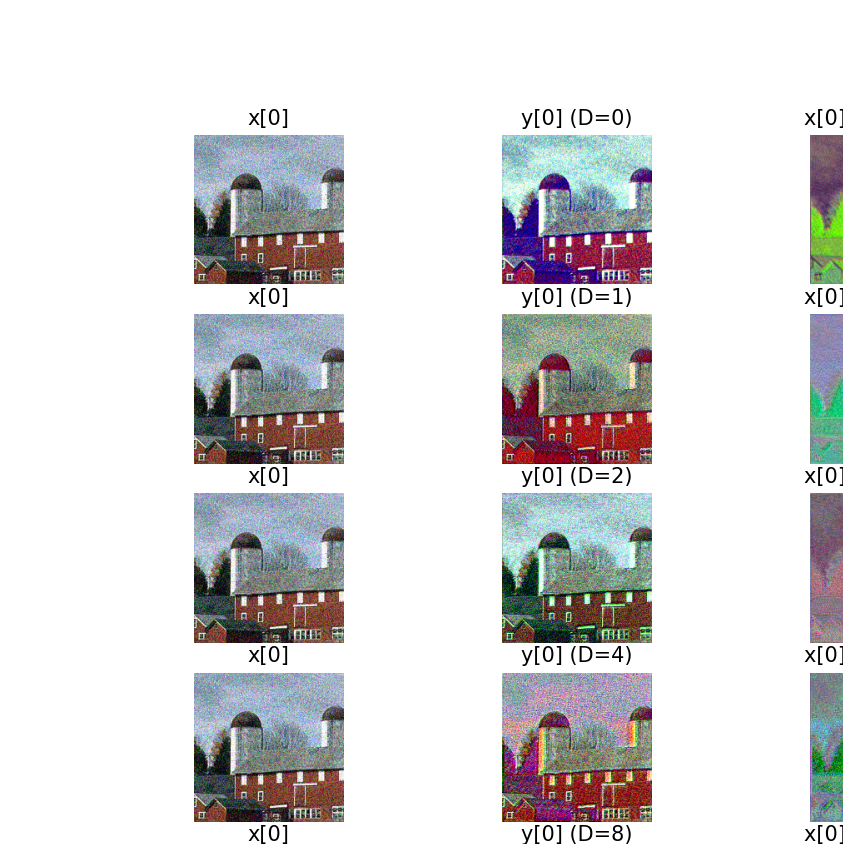

In [122]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)
    
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')


In [124]:
class DenoisingStatsManager(StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [125]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

In [127]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/denoising1", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


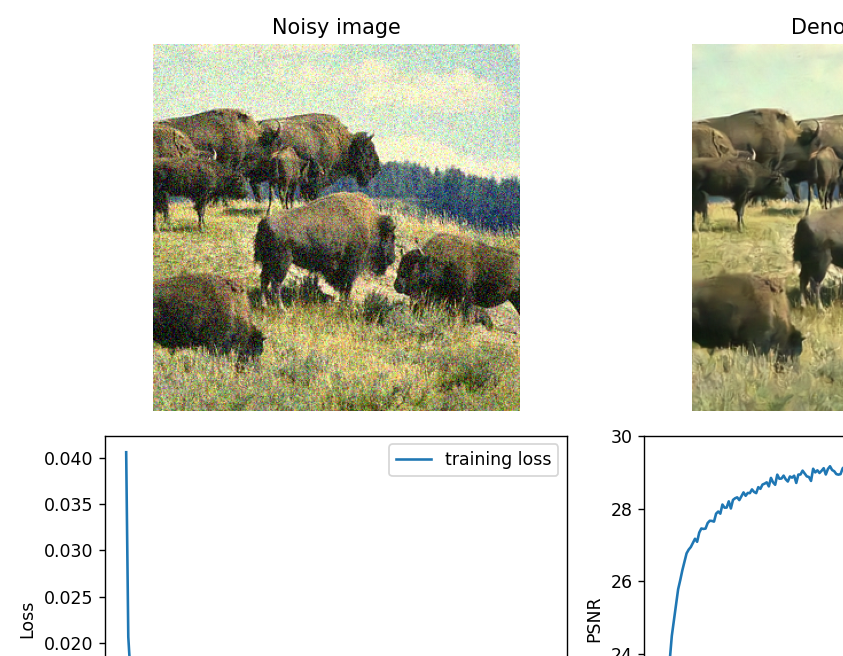

Start/Continue training from epoch 0
Epoch 1 | Time: 46.85s | Training Loss: 0.040656 | Evaluation Loss: 0.023540
Epoch 2 | Time: 46.47s | Training Loss: 0.020621 | Evaluation Loss: 0.017991
Epoch 3 | Time: 47.04s | Training Loss: 0.016743 | Evaluation Loss: 0.015086
Epoch 4 | Time: 47.51s | Training Loss: 0.014282 | Evaluation Loss: 0.013235
Epoch 5 | Time: 46.87s | Training Loss: 0.012911 | Evaluation Loss: 0.011829
Epoch 6 | Time: 47.45s | Training Loss: 0.011655 | Evaluation Loss: 0.010963
Epoch 7 | Time: 46.66s | Training Loss: 0.010628 | Evaluation Loss: 0.010169
Epoch 8 | Time: 48.42s | Training Loss: 0.010047 | Evaluation Loss: 0.009721
Epoch 9 | Time: 46.83s | Training Loss: 0.009439 | Evaluation Loss: 0.009064
Epoch 10 | Time: 47.04s | Training Loss: 0.008920 | Evaluation Loss: 0.008660
Epoch 11 | Time: 46.39s | Training Loss: 0.008481 | Evaluation Loss: 0.008360
Epoch 12 | Time: 45.68s | Training Loss: 0.008286 | Evaluation Loss: 0.008133
Epoch 13 | Time: 45.83s | Training L

Epoch 106 | Time: 48.01s | Training Loss: 0.004895 | Evaluation Loss: 0.005360
Epoch 107 | Time: 46.81s | Training Loss: 0.004836 | Evaluation Loss: 0.005401
Epoch 108 | Time: 46.20s | Training Loss: 0.004857 | Evaluation Loss: 0.005222
Epoch 109 | Time: 46.05s | Training Loss: 0.004896 | Evaluation Loss: 0.005207
Epoch 110 | Time: 47.16s | Training Loss: 0.004873 | Evaluation Loss: 0.005434
Epoch 111 | Time: 47.52s | Training Loss: 0.004954 | Evaluation Loss: 0.005257
Epoch 112 | Time: 48.84s | Training Loss: 0.004789 | Evaluation Loss: 0.005515
Epoch 113 | Time: 46.27s | Training Loss: 0.004990 | Evaluation Loss: 0.005232
Epoch 114 | Time: 45.33s | Training Loss: 0.004840 | Evaluation Loss: 0.005299
Epoch 115 | Time: 46.23s | Training Loss: 0.004967 | Evaluation Loss: 0.005264
Epoch 116 | Time: 45.55s | Training Loss: 0.004845 | Evaluation Loss: 0.005220
Epoch 117 | Time: 46.62s | Training Loss: 0.004860 | Evaluation Loss: 0.005167
Epoch 118 | Time: 45.77s | Training Loss: 0.004676 |

In [128]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

<IPython.core.display.Javascript object>


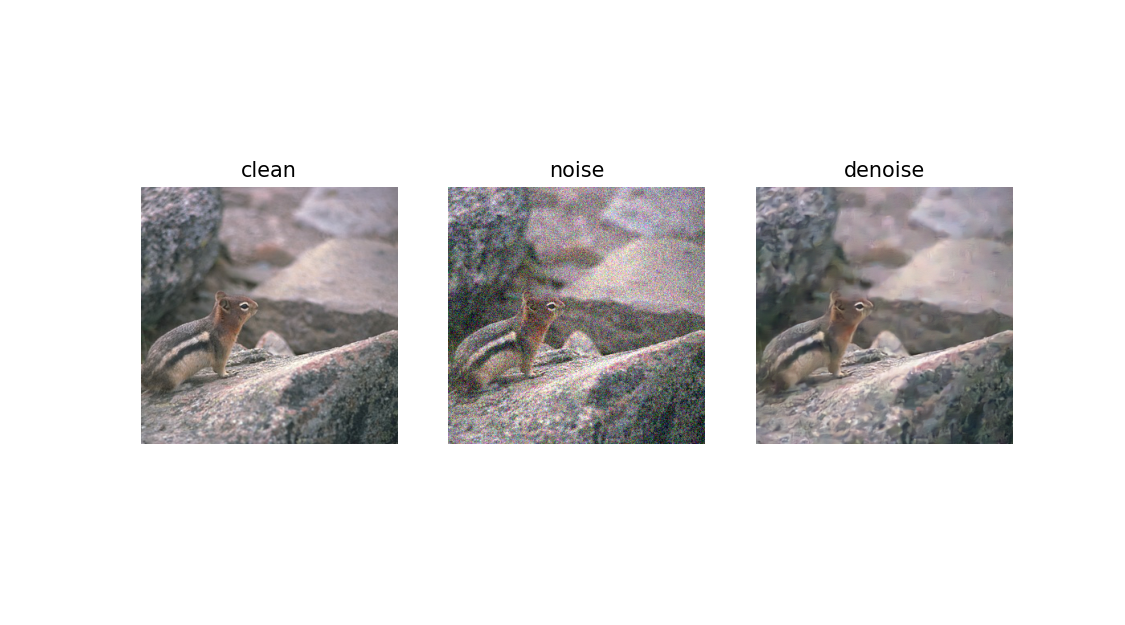

In [129]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[12]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

In [130]:
exp1.evaluate()

{'loss': 0.004985340135172009, 'PSNR': tensor(29.0992)}